In [1]:
from brian2 import *
from brian2modelfitting import *

INFO       Cache size for target "cython": 1104 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/alteska/.cython/brian_extensions" directory. [brian2]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyte

In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 0.01*ms
defaultclock.dt = dt


## generate noise

In [4]:
tau = 1*ms

In [5]:
eqs_noise = Equations('''
dnoise/dt = -noise/tau + tau**-0.5*xi : 1
I = noise * 2 * nA: amp
''')


In [6]:
start_scope()
G = NeuronGroup(1, eqs_noise)

In [7]:
mon0 = StateMonitor(G, ['I'], record=0)

In [8]:
duration = 50*second
run(duration)

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


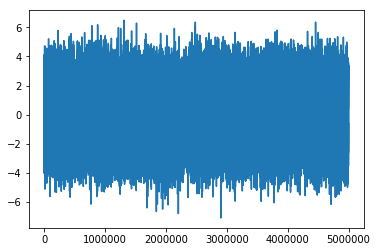

In [9]:
inp_cur = mon0.I[0]/nA
plot(inp_cur);

## HH with external noise current

In [10]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV

In [11]:
# Generate a step-current input and an "experimental" voltage trace
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

In [12]:
I = TimedArray(inp_cur*nA, dt=dt)

In [13]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [14]:
start_scope()
neur = NeuronGroup(1, eqsHH, 
                threshold='v > -40*mV',
                refractory='v > -40*mV',
                method='exponential_euler'
               )
neur.v = El

neur.set_states(params_correct, units=False)
spike_mon = SpikeMonitor(neur)
mon = StateMonitor(neur, 'v', record=0)

run(duration)


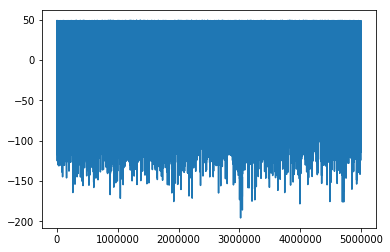

In [15]:
voltage1 = mon.v[0]/mV
plot(voltage1);

In [16]:
out_spikes1 = [spike_mon.spike_trains()[0]/ms]
out_spikes1

[array([1.914000e+01, 2.566000e+01, 4.607000e+01, ..., 4.992593e+04,
        4.996567e+04, 4.997614e+04])]

In [17]:
spike_mon.count / duration

array([30.1]) * hertz

In [18]:
out_spikes1

[array([1.914000e+01, 2.566000e+01, 4.607000e+01, ..., 4.992593e+04,
        4.996567e+04, 4.997614e+04])]

In [19]:
np.savetxt('out_spikes2nA.csv', out_spikes1, delimiter=",")
np.savetxt('inp_cur2nA.csv', inp_cur, delimiter=',')
np.savetxt('voltage2nA.csv', voltage1, delimiter=',')

In [20]:
my_data = genfromtxt('out_spikes2nA.csv', delimiter=',')
my_data

array([1.914000e+01, 2.566000e+01, 4.607000e+01, ..., 4.992593e+04,
       4.996567e+04, 4.997614e+04])

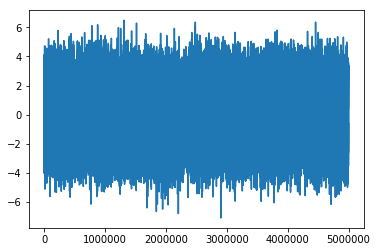

In [21]:
my_data = genfromtxt('inp_cur2nA.csv', delimiter=',')
plot(my_data);